## Image Generation

#### Importing Required Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

#### Importing the MNIST Dataset 

In [ ]:
train_dataset = pd.read_csv (r'/mnist_train.csv') 
train_dataset = train_dataset.drop(labels = ['label'], axis = 1) 
train_dataset = train_dataset.values.reshape(-1, 28, 28)
train_dataset = train_dataset/255.0 #normalize
print(train_dataset.shape)

(60000, 28, 28)


#### Show sample data

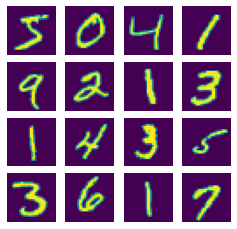

In [ ]:
plt.figure(figsize=(4,4))
for i in range (16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_dataset[i,:,:])
  plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.1) 

#### Converting Data to Tensor

In [ ]:
train_dataset = torch.Tensor(train_dataset)
random_seed = 1 #randomization
batch_size = 128 #same as DCGAN Paper
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)

#### Set Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Random noise

In [ ]:
def random_noise(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

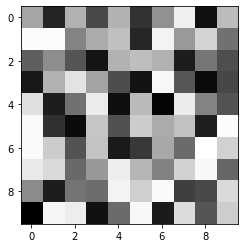

In [ ]:
a = random_noise(64, 100)
b = a[2]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

### GAN 

#### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2) 
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_drop(x)
        x = x.view(-1, self.flatten_features(x))
        x = self.fc(x)
        
        return x
    
    def flatten_features(self, x): 
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features
    
    

#### Generator

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.conv_transpose1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.conv_transpose2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv_transpose4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = F.relu(self.conv_transpose3(x))
        x = self.conv_transpose4(x)
        x = torch.tanh(x)
        
        return x

In [ ]:
D = Discriminator()
G = Generator()
print(D)
print(G)
#Passing to the device
D = D.to(device)
G = G.to(device)

D = D.float()
G = G.float()


Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=

In [ ]:
criterion = nn.BCEWithLogitsLoss() #with sigmoid
d_optim = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999)) #values from paper
g_optim = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

#### Calculate Discriminator Loss

In [ ]:
def d_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = criterion(real_out.squeeze(), real_label.squeeze())
    return real_loss

def d_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = criterion(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def d_total_loss(real_out, fake_out):
    real_loss = d_real_loss(real_out)
    fake_loss = d_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

#### Generator Loss

In [ ]:
def g_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    g_Loss = criterion(gen_disc_out.squeeze(), label.squeeze())
    return g_Loss

#### Training the Generator and Discriminator

In [ ]:
def train(D, G, d_optim, g_optim, train_loader, batch_size = 100, epochs = 100, gen_input_size = 100):
    
    d_losses = []
    g_losses = []
    
    #sample 
    sample_size = 25
    fixed_samples = random_noise(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)
    
    #training mode
    D.train()
    G.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        
        for train_x in train_loader:
            
            #train discriminator 
            d_optim.zero_grad() 
            
            train_x = train_x*2 - 1          #transforming images
            train_x = train_x.to(device)     #pass to device
            real_out = D(train_x.float())    
            
            disc_gen_in = random_noise(batch_size, gen_input_size) #input random noise
            disc_gen_in = disc_gen_in.to(device)   #Passing to GPU
            
            disc_gen_out = G(disc_gen_in.float()).detach()  #detaching to stop training to generator
            fake_out = D(disc_gen_out.float()) #passing to discriminator
            #Backward propagation
            disc_loss = d_total_loss(real_out, fake_out)  #Calculating loss
            disc_loss_total += disc_loss
            disc_loss.backward()
            d_optim.step()  
        
            #Generator training
            
            g_optim.zero_grad() #restart loop without losses from last step
            
            
            gen_out = G(disc_gen_in.float())     #pass noise intogenerator
            gen_disc_out = D(gen_out.float())       #pass to discrminator
            
            g_Loss = g_loss(gen_disc_out)  #calculating loss
            gen_loss_total += g_Loss
            g_Loss.backward()
            g_optim.step()
        
        d_losses.append(disc_loss_total)
        g_losses.append(gen_loss_total)
        
        #plotting for each epoch
        if epoch%1 == 0:
            G.eval()                    #generator goes into eval mode to get sample images         
            samples = G(fixed_samples.float())
            G.train()                   #generator goes back to training mode
            
        #generate images
            fig, axes = plt.subplots(figsize=(5,5), nrows=5, ncols=5, sharey=True, sharex=True) ;
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        
        #printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_loader), ", Generator Loss = ", gen_loss_total/len(train_loader))    
    
    return d_losses, g_losses

Epoch  0 : Discriminator Loss =  tensor(1.2764, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8880, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(1.2778, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8841, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(1.2793, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8829, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(1.2801, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8841, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(1.2794, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8818, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(1.2817, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8805, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  6 :

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch  20 : Discriminator Loss =  tensor(1.2839, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8758, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  21 : Discriminator Loss =  tensor(1.2862, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8716, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  22 : Discriminator Loss =  tensor(1.2872, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8730, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  23 : Discriminator Loss =  tensor(1.2871, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8696, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  24 : Discriminator Loss =  tensor(1.2885, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8712, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  25 : Discriminator Loss =  tensor(1.2894, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8633, device='cuda:0', grad_fn=<DivBackward0>)
Epoc

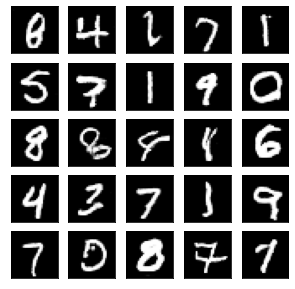

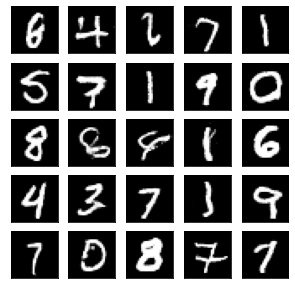

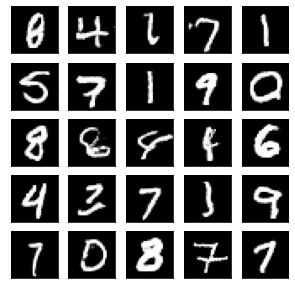

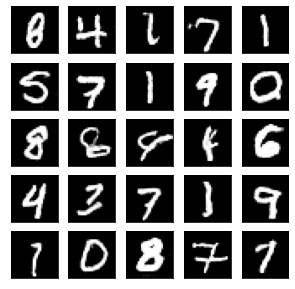

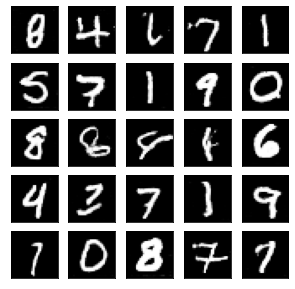

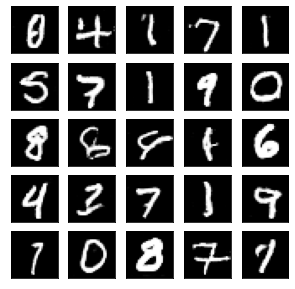

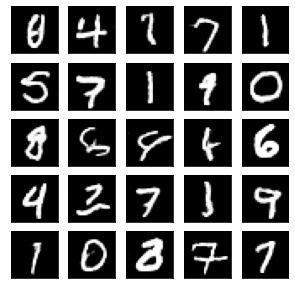

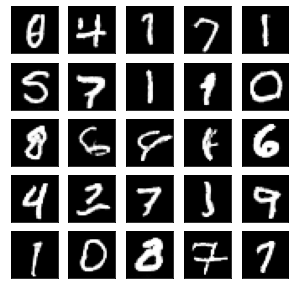

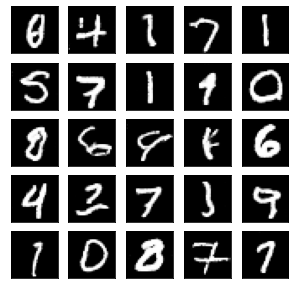

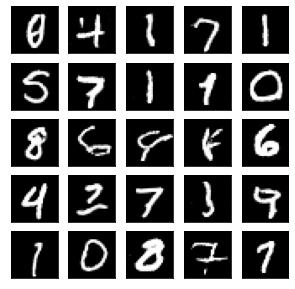

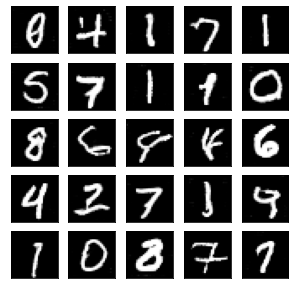

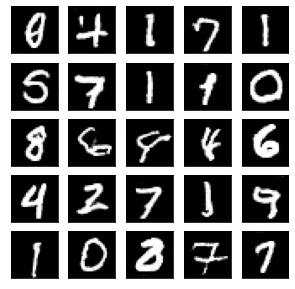

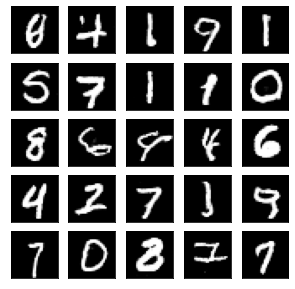

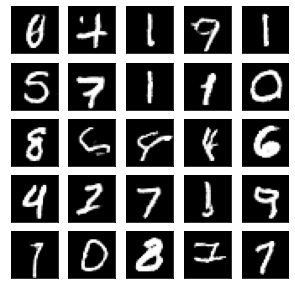

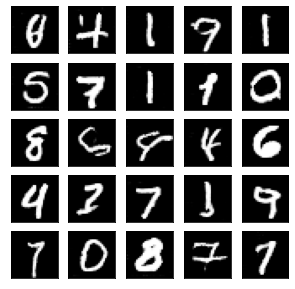

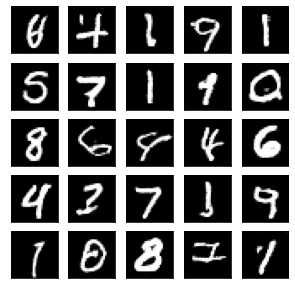

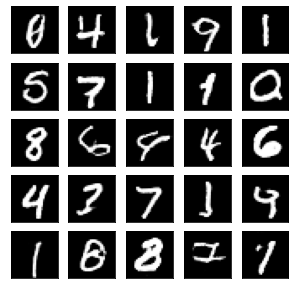

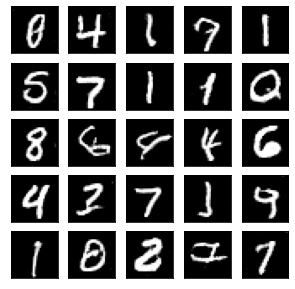

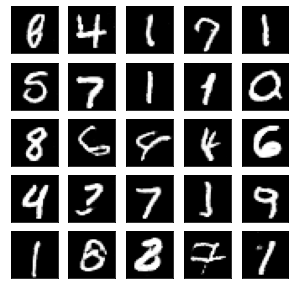

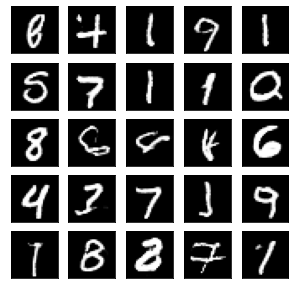

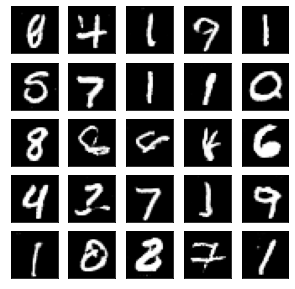

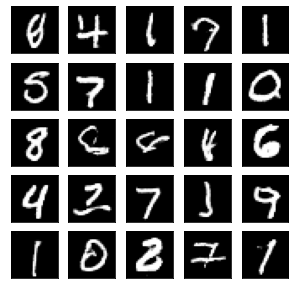

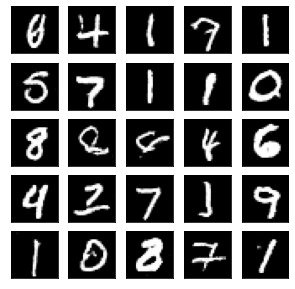

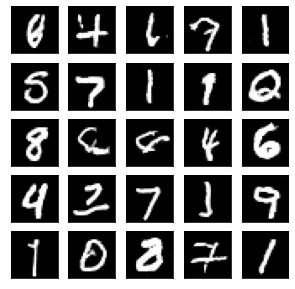

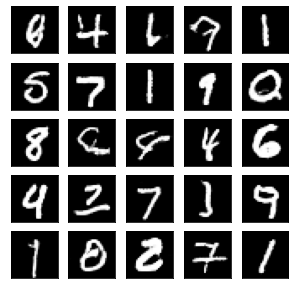

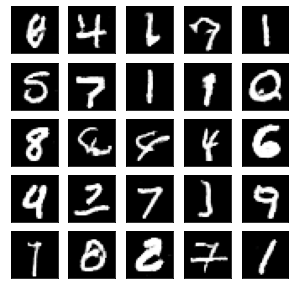

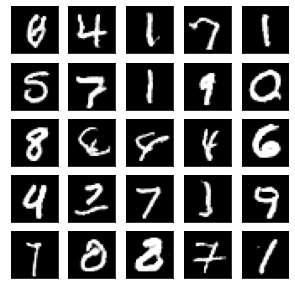

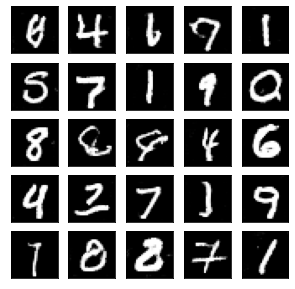

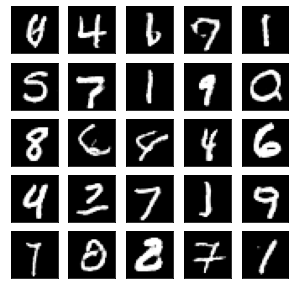

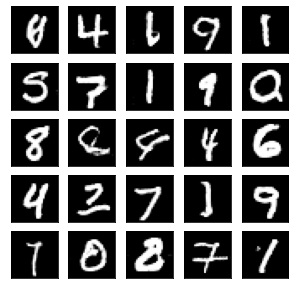

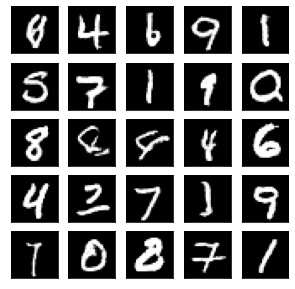

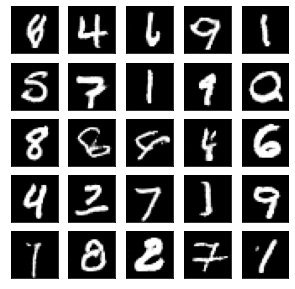

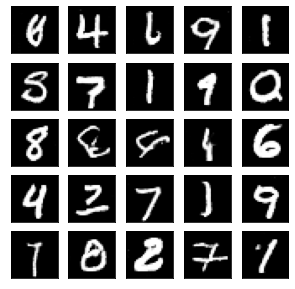

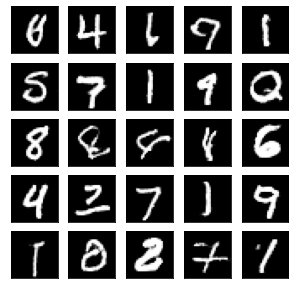

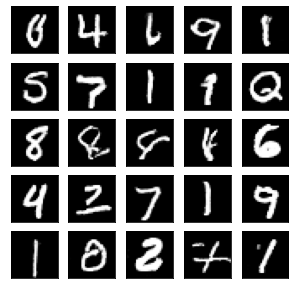

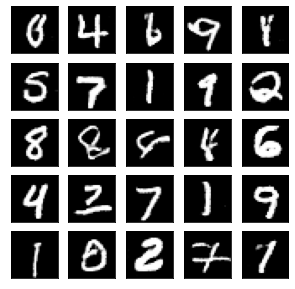

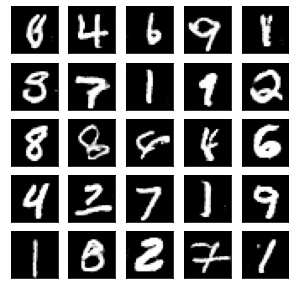

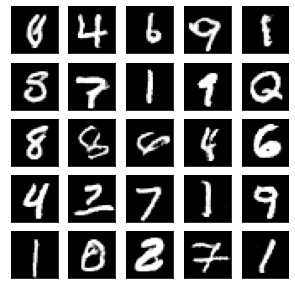

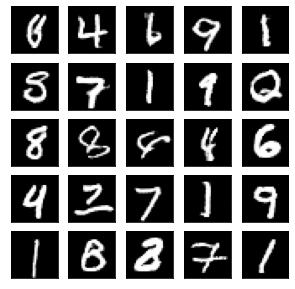

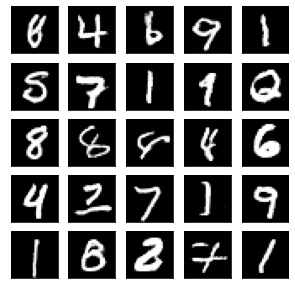

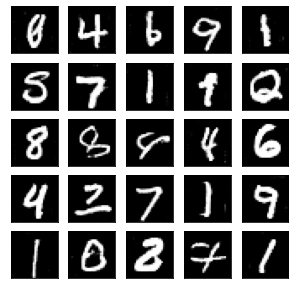

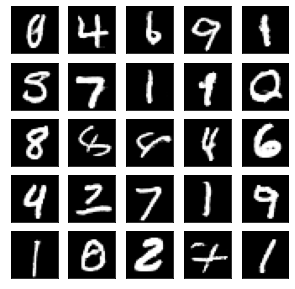

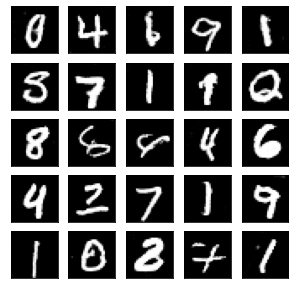

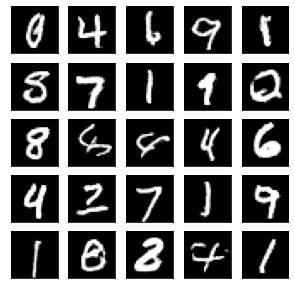

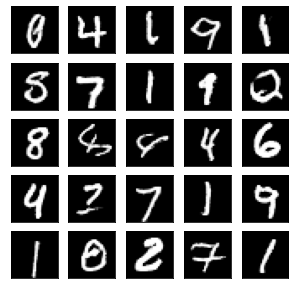

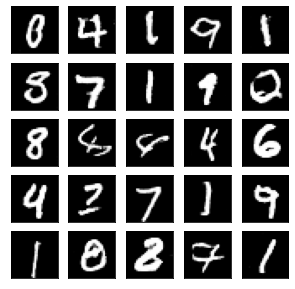

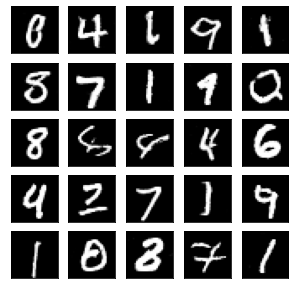

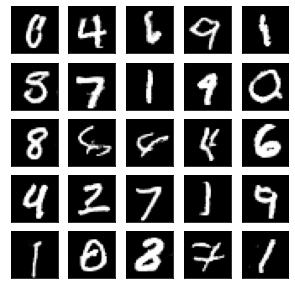

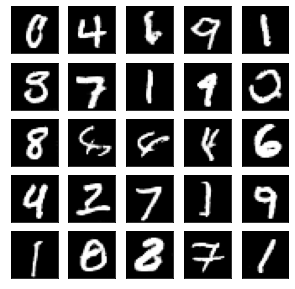

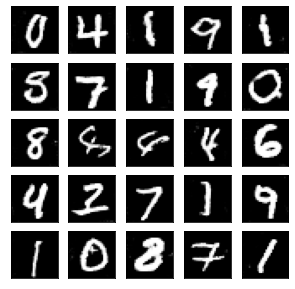

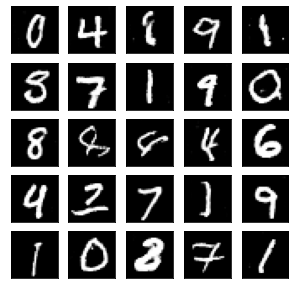

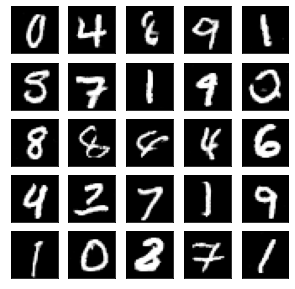

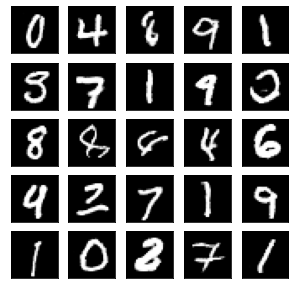

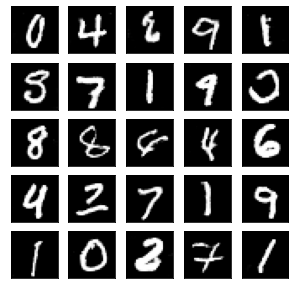

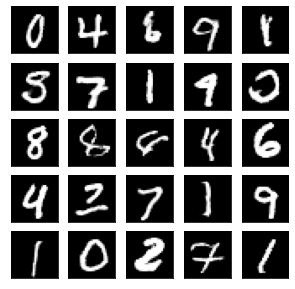

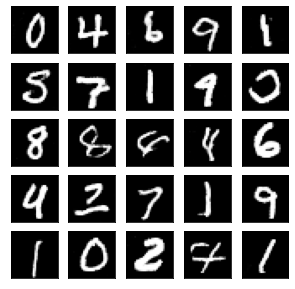

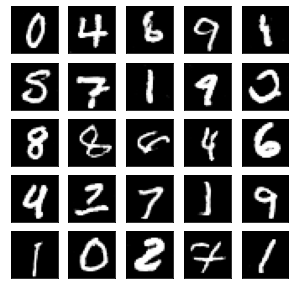

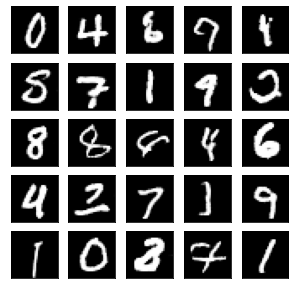

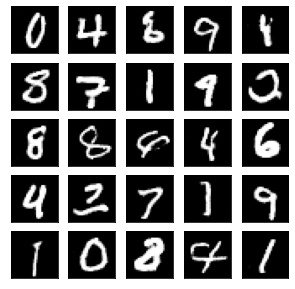

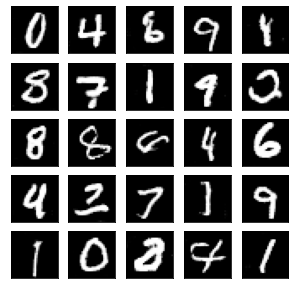

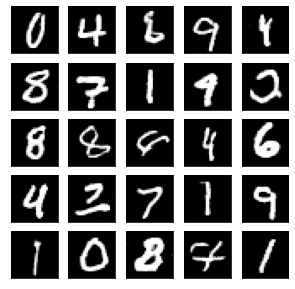

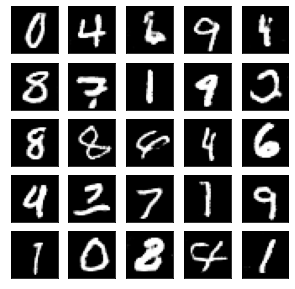

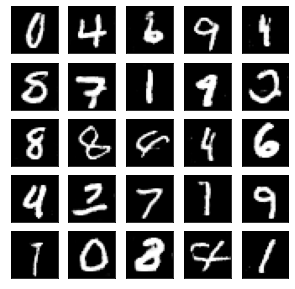

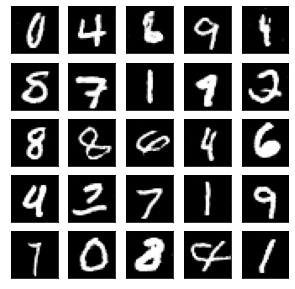

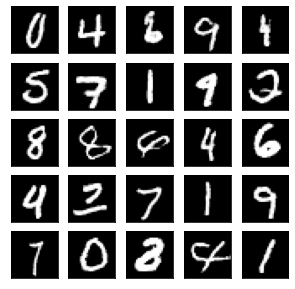

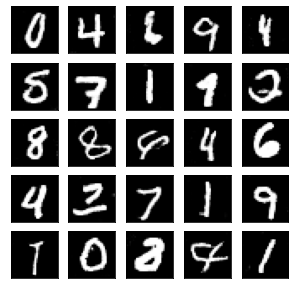

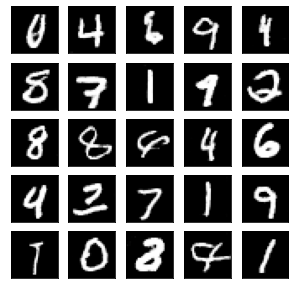

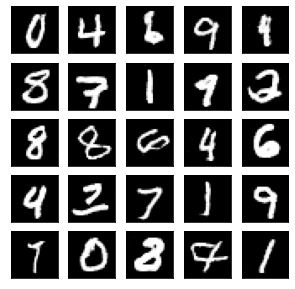

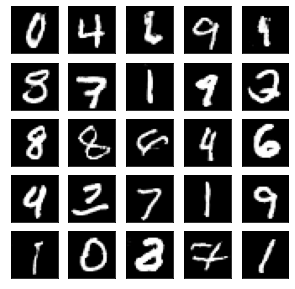

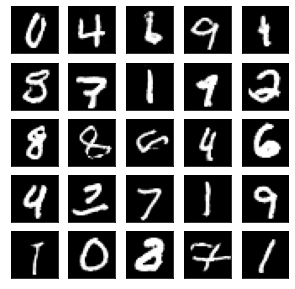

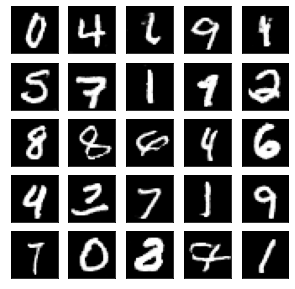

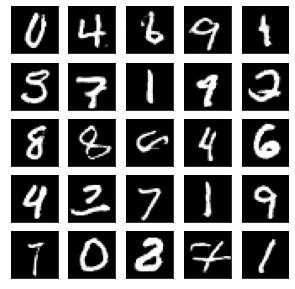

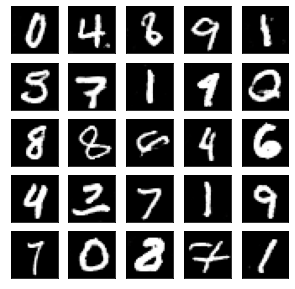

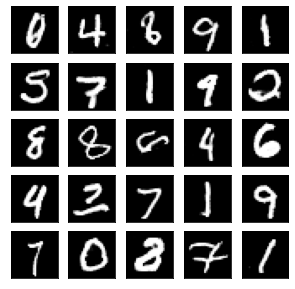

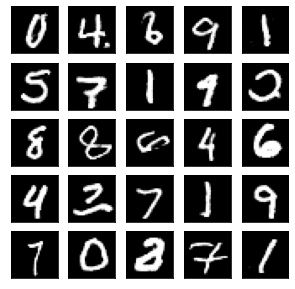

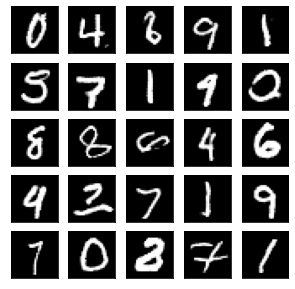

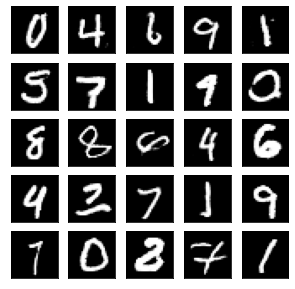

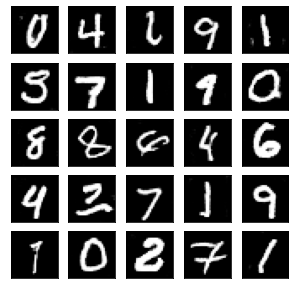

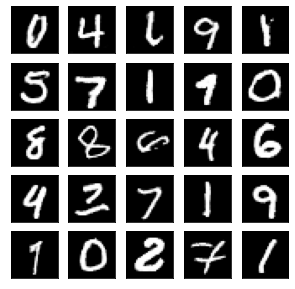

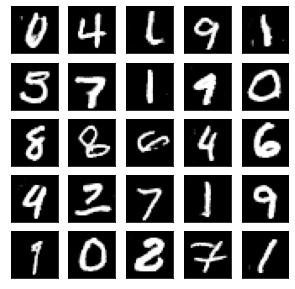

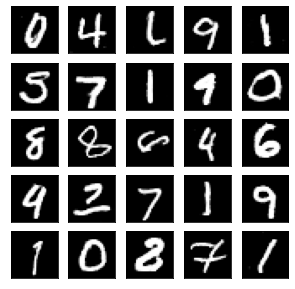

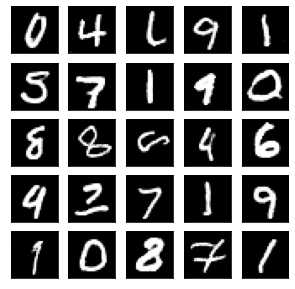

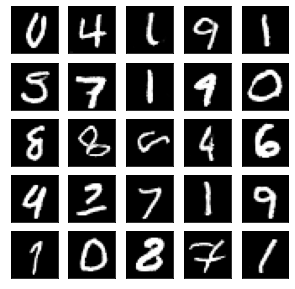

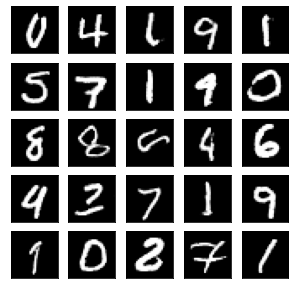

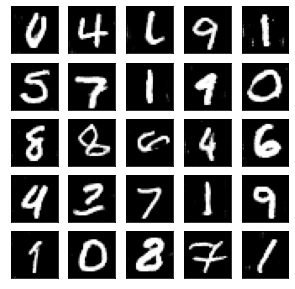

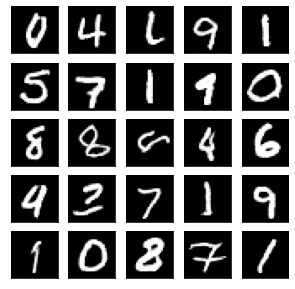

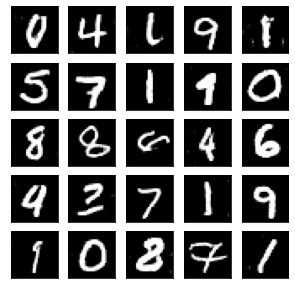

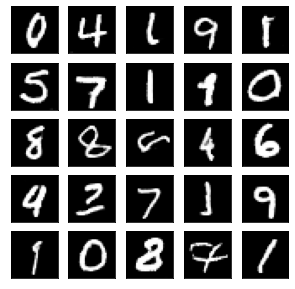

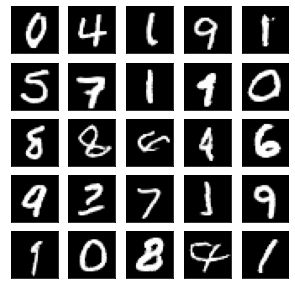

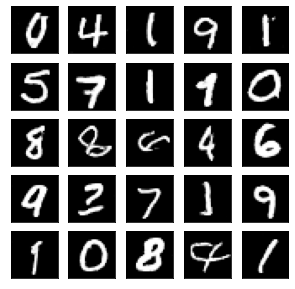

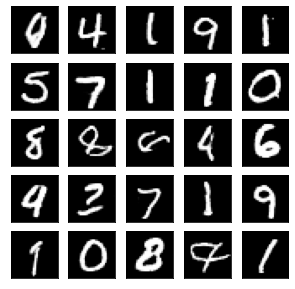

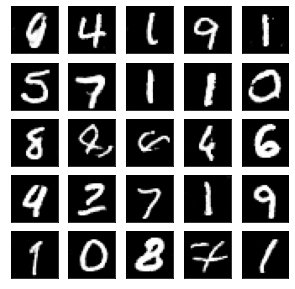

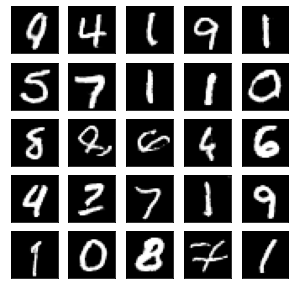

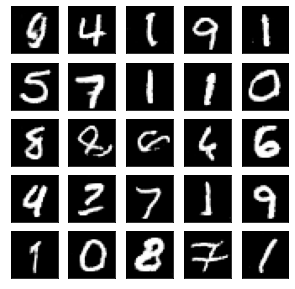

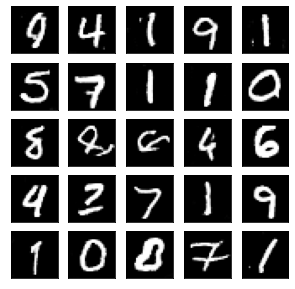

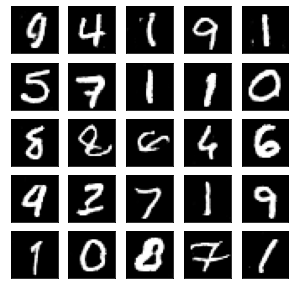

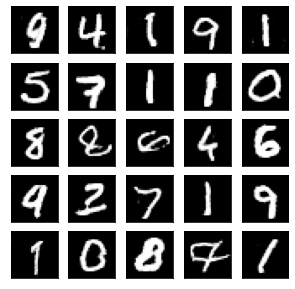

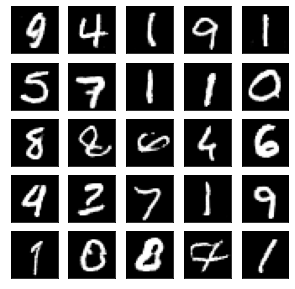

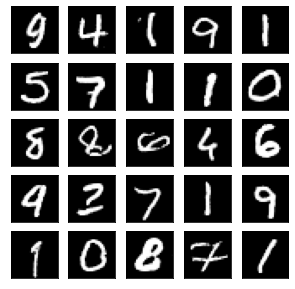

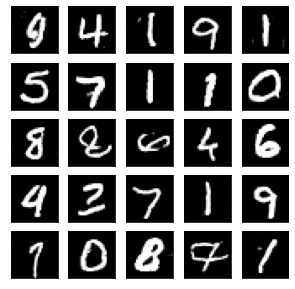

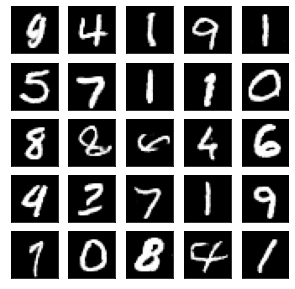

In [ ]:
d_losses, g_losses = train(D, G, d_optim, g_optim, train_loader, batch_size)